In [1]:
import sys, os

if __name__ == "__main__":
    os.chdir("../")
    sys.path.append("./../src/data")
    sys.path.append("./../src/events")
    sys.path.append("./../src/probability")
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
from importer import *
from processer import *
from events import sim_events, list_of_params, ic_params
from functions import perform_chisq
from scipy.stats import chi2
from event_processing import *
import pickle
from multiprocessing import Pool

plt.rcParams["figure.figsize"] = [8, 4]
plt.rcParams["figure.dpi"] = 100
matplotlib.rc("text", usetex=True)
matplotlib.rc("text.latex", preamble=r"\usepackage{amsmath}")
np.set_printoptions(linewidth=200)

giunti_contour_cl90 = pd.read_csv(
    "../src/data/files/giunti_cl90.csv", header=None, names=["s24", "dm41"]
).sort_values("dm41")
IC_contour_cl90 = pd.read_csv(
    "../src/data/files/ic_cl90.csv", header=None, names=["s24", "dm41"]
).sort_values("dm41")
giunti_contour_cl99 = pd.read_csv(
    "../src/data/files/giunti_cl99.csv", header=None, names=["s24", "dm41"]
).sort_values("dm41")
IC_contour_cl99 = pd.read_csv(
    "../src/data/files/ic_cl99.csv", header=None, names=["s24", "dm41"]
).sort_values("dm41")
ic_34_cl90 = pd.read_csv(
    "../src/data/files/ic_34_cl90.csv", header=None, names=["s24", "s34"]
).sort_values("s34")
ic_34_cl99 = pd.read_csv(
    "../src/data/files/ic_34_cl99.csv", header=None, names=["s24", "s34"]
).sort_values("s34")

In [2]:
ndim = 4
N = 13
alpha = 0.99
precomputed_events = False
tau = True

dm41_range = np.logspace(-1, 1, 20)
s24_range = np.logspace(-2, np.log10(0.2), 20)
s34_range = None  # s24_range
param_list = list_of_params(
    ic_params,
    dm41_range,
    s24_range,
    s34_range=s34_range,
    s24_eq_s34=True,
    s24_2x_s34=False,
)
"""
param_list = list_of_params(ic_params, dm41_range, s24_range,s34_range=s34_range,s24_eq_s34=False, s24_2x_s34=False)
#for p in param_list: # Assert all dicts returned from param_list have precomputed probs.
#    assert is_precomputed(N=N,ndim=ndim, dict=p,check=False)
p = Pool()
pars = [[N,ndim,[p], False, False] for p in param_list]
param_list=p.starmap(return_precomputed, pars)
p.close()
dm41_range = np.sort(np.unique(np.array([p[0]['dm_41'] for p in param_list])))
s24_range = np.sin(2*np.sort(np.unique(np.array([p[0]['theta_24'] for p in param_list]))))**2
s34_range = np.sin(2*np.sort(np.unique(np.array([p[0]['theta_34'] for p in param_list]))))**2
"""
param_list = return_precomputed(N, ndim, params=param_list, quick=True)
dm41_range = np.sort(np.unique(np.array([p["dm_41"] for p in param_list])))
s24_range = (
    np.sin(2 * np.sort(np.unique(np.array([p["theta_24"] for p in param_list])))) ** 2
)
s34_range = (
    np.sin(2 * np.sort(np.unique(np.array([p["theta_34"] for p in param_list])))) ** 2
)
print(dm41_range)
print(s24_range)
print(s34_range)

[ 0.1         0.1274275   0.16237767  0.20691381  0.26366509  0.33598183  0.42813324  0.54555948  0.6951928   0.88586679  1.12883789  1.43844989  1.83298071  2.33572147  2.97635144  3.79269019
  4.83293024  6.15848211  7.8475997  10.        ]
[0.01       0.0117078  0.01370726 0.01604818 0.01878889 0.02199765 0.02575441 0.03015274 0.03530223 0.04133114 0.04838967 0.05665365 0.06632896 0.07765661 0.0909188  0.1064459  0.12462472 0.14590812
 0.1708263  0.2       ]
[0.01       0.0117078  0.01370726 0.01604818 0.01878889 0.02199765 0.02575441 0.03015274 0.03530223 0.04133114 0.04838967 0.05665365 0.06632896 0.07765661 0.0909188  0.1064459  0.12462472 0.14590812
 0.1708263  0.2       ]


In [10]:
if tau:
    tau_str = "tau"
else:
    tau_str = "notau"
if not precomputed_events:
    p = Pool()
    data = [
        (alpha, N, p, False, False, [False, np.median(Ereco), 0], tau)
        for p in param_list
    ]
    H1_events_list = p.starmap(sim_events, data)
    p.close()
    H0_events = sim_events(
        alpha=alpha,
        npoints=N,
        params=param_list[0],
        null=True,
        multi=False,
        spectral_shift=[False, np.median(Ereco), 0],
        tau=tau,
    )

    if len(s34_range) > 1:
        pickle.dump(
            H1_events_list,
            open(
                f"../pre_computed/H1_34_N{N}_{len(dm41_range)}x{len(s24_range)}x{len(s34_range)}_{tau_str}_s34_eq_s24.p",
                "wb",
            ),
        )
    else:
        pickle.dump(
            H1_events_list,
            open(
                f"../pre_computed/H1_no34_N{N}_{len(dm41_range)}x{len(s24_range)}_{tau_str}.p",
                "wb",
            ),
        )
    pickle.dump(H0_events, open(f"../pre_computed/H0_N{N}.p", "wb"))


if len(s34_range) > 1:
    H1_events_list = pickle.load(
        open(
            f"../pre_computed/H1_34_N{N}_{len(dm41_range)}x{len(s24_range)}x{len(s34_range)}_{tau_str}_s34_eq_s24.p",
            "rb",
        )
    )
else:
    H1_events_list = pickle.load(
        open(
            f"../pre_computed/H1_no34_N{N}_{len(dm41_range)}x{len(s24_range)}_{tau_str}.p",
            "rb",
        )
    )
H0_events = pickle.load(open(f"../pre_computed/H0_N{N}.p", "rb"))


gamma = 0.3
delta_T = (
    np.sum(
        sim_events(
            alpha=alpha,
            npoints=N,
            params=param_list[0],
            null=True,
            multi=False,
            spectral_shift=[True, np.median(Ereco), gamma],
            tau=tau,
        )
    )
    - np.sum(H0_events)
) / np.sum(H0_events)

H0_normalized, H1_list_normalized = normalize_events(H0_events, H1_events_list, z_bins)

FileNotFoundError: [Errno 2] No such file or directory: '../pre_computed/H1_34_N13_20x20x20_tau_s34_eq_s24.p'

In [4]:
sigma_a = 0.25
sigma_b = 0.04
f = 0.05
deltachi, best_index, H1_chisq, H0_chisq = get_deltachi(
    H1_list_normalized,
    H0_normalized,
    dm41_range,
    s24_range,
    delta_T,
    [sigma_a, sigma_b],
    f,
    x0=[1, 0, 0],
)
s24_cl90, s24_cl99, dm41_cl90, dm41_cl99 = get_contour(deltachi, dm41_range, s24_range)

In [5]:
param_list[best_index]

{'theta_12': 0.5837630475986898,
 'theta_13': 0.15494769630192953,
 'theta_23': 0.7695841386786632,
 'theta_34': 0,
 'theta_24': 0.054207419826744194,
 'theta_14': 0,
 'delta_ij': 3.4033920413889422,
 'dm_21': 7.53e-05,
 'dm_31': 0.0025153,
 'dm_41': 1.438449888287663}

In [6]:
# s24_cl90_notau_s24, s24_cl99_notau_s24, dm41_cl90_notau_s24, dm41_cl99_notau_s24= s24_cl90, s24_cl99, dm41_cl90, dm41_cl99
# s24_cl90_notau_s34, s24_cl99_notau_s34, dm41_cl90_notau_s34, dm41_cl99_notau_s34= s24_cl90, s24_cl99, dm41_cl90, dm41_cl99
s24_cl90_tau_s24, s24_cl99_tau_s24, dm41_cl90_tau_s24, dm41_cl99_tau_s24 = (
    s24_cl90,
    s24_cl99,
    dm41_cl90,
    dm41_cl99,
)
# s24_cl90_tau_s34, s24_cl99_tau_s34, dm41_cl90_tau_s34, dm41_cl99_tau_s34= s24_cl90, s24_cl99, dm41_cl90, dm41_cl99

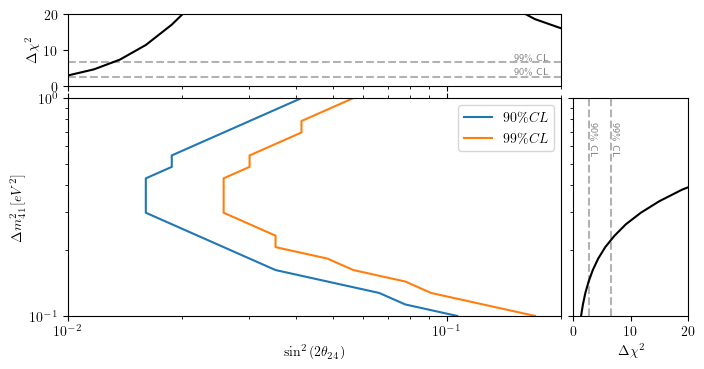

In [8]:
fig, ax = plt.subplots(
    2, 2, gridspec_kw={"width_ratios": [1.5, 0.35], "height_ratios": [1, 3]}
)
ax = ax.flatten()
plt.subplots_adjust(hspace=0.08, wspace=0.04)
ax[0].plot(s24_range, np.mean(deltachi, axis=0), c="black")
ax[0].axhline(chi2.ppf(q=0.90, df=1), ls="dashed", alpha=0.3, c="black")
ax[0].axhline(chi2.ppf(q=0.99, df=1), ls="dashed", alpha=0.3, c="black")
ax[0].set_xscale("log")
ax[1].axis("off")
ax[2].plot(s24_cl90_tau_s24, dm41_cl90_tau_s24, label="$90\% CL$ ")
ax[2].plot(s24_cl99_tau_s24, dm41_cl99_tau_s24, label="$99\% CL$ ")
ax[2].set_xscale("log")
ax[2].set_xlim((1e-2, 0.2))
ax[2].set_ylim((1e-1, 1))

ax[0].set_ylim((0, 20))
ax[0].set_xlim((1e-2, 0.2))
ax[3].set_xlim((0, 20))
ax[3].set_ylim((1e-1, 1.0001))

ax[2].set_yscale("log")
ax[3].plot(np.mean(deltachi, axis=1), dm41_range, c="black")
ax[3].axvline(chi2.ppf(q=0.90, df=1), ls="dashed", alpha=0.3, c="black")
ax[3].axvline(chi2.ppf(q=0.99, df=1), ls="dashed", alpha=0.3, c="black")
ax[3].text(chi2.ppf(q=0.90, df=1), 0.55, "90\% CL", rotation=-90, fontsize=7, alpha=0.5)
ax[3].text(chi2.ppf(q=0.99, df=1), 0.55, "99\% CL", rotation=-90, fontsize=7, alpha=0.5)
ax[0].text(
    0.15, chi2.ppf(q=0.90, df=1) + 0.5, "90\% CL", rotation=0, fontsize=7, alpha=0.5
)
ax[0].text(
    0.15, chi2.ppf(q=0.99, df=1) + 0.5, "99\% CL", rotation=0, fontsize=7, alpha=0.5
)
ax[3].set_yscale("log")

ax[0].set_ylabel(r"$\Delta \chi^2$")
ax[3].set_xlabel(r"$\Delta \chi^2$")
ax[2].set_xlabel("$\sin^2{(2\\theta_{24})}$", fontsize=10)
ax[2].set_ylabel("$\\Delta m^2_{41} \, [eV^2]$", fontsize=10)
ax[3].tick_params(labelleft=False)
ax[2].tick_params(axis="x", which="both", top=True)
ax[2].tick_params(axis="y", which="minor", labelleft=False)
ax[0].tick_params(axis="x", which="both", labelbottom=False)
ax[2].legend()

Text(0.05, 0.65, '$\\pi_N = 0.25$\n$\\pi_\\theta = 0.04$\n$\\Delta \\gamma = 0.3$\n$f = 0.05$\n')

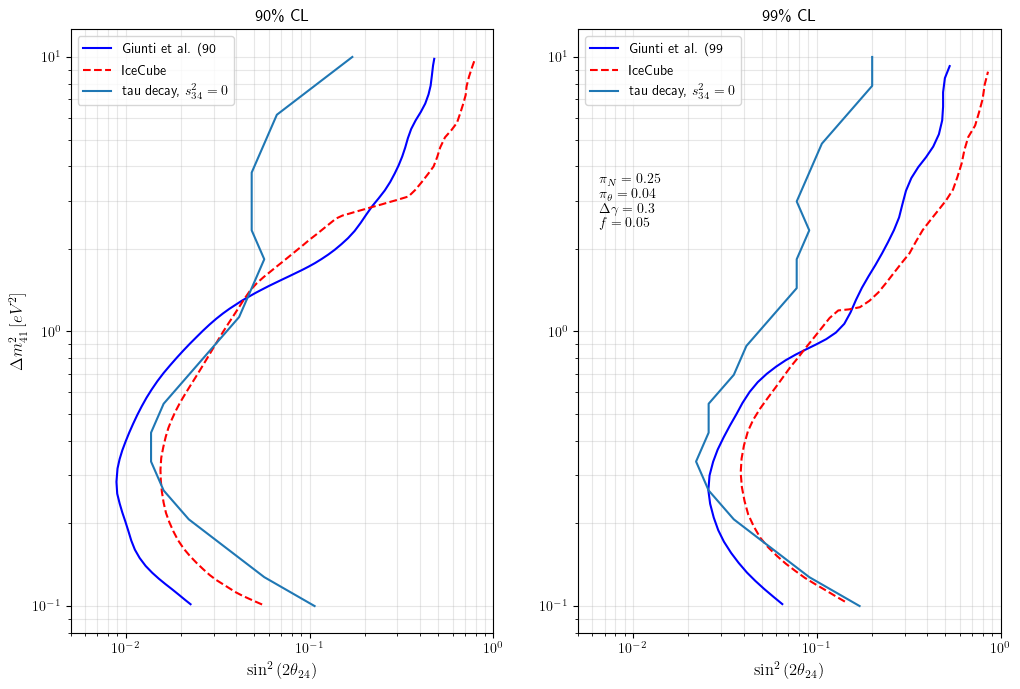

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(12, 8))

ax[0].plot(
    giunti_contour_cl90.s24,
    giunti_contour_cl90.dm41,
    label="Giunti et al. (90% CL)",
    c="b",
)
ax[0].plot(IC_contour_cl90.s24, IC_contour_cl90.dm41, label="IceCube", c="red", ls="--")
ax[0].plot(s24_cl90_tau_s24, dm41_cl90_tau_s24, label="tau decay, $s_{34}^2=0$ ")
# ax[0].plot(s24_cl90_tau_s34, dm41_cl90_tau_s34, label='tau decay, $s_{34}^2=s_{24}^2$ ')

ax[1].plot(
    giunti_contour_cl99.s24,
    giunti_contour_cl99.dm41,
    label="Giunti et al. (99% CL)",
    ls="solid",
    c="b",
)
ax[1].plot(IC_contour_cl99.s24, IC_contour_cl99.dm41, label="IceCube", c="red", ls="--")
ax[1].plot(s24_cl99_tau_s24, dm41_cl99_tau_s24, label="tau decay, $s_{34}^2=0$ ")
# ax[1].plot(s24_cl99_tau_s34, dm41_cl99_tau_s34, label='tau decay, $s_{34}^2=s_{24}^2$ ')


ax[0].set_xscale("log")
ax[1].set_xscale("log")
ax[0].set_yscale("log")
ax[1].set_yscale("log")
ax[0].set_xlim((5e-3, 1))
ax[1].set_xlim((5e-3, 1))
# ax[0].set_ylim((1e-1,1))
# ax[1].set_ylim((1e-1,1))
ax[0].set_xlabel("$\sin^2{(2\\theta_{24})}$", fontsize=12)
ax[1].set_xlabel("$\sin^2{(2\\theta_{24})}$", fontsize=12)
ax[0].set_ylabel("$\\Delta m^2_{41} \, [eV^2]$", fontsize=12)
ax[0].grid(True, which="both", alpha=0.3)
ax[1].grid(True, which="both", alpha=0.3)
ax[0].set_title("90\% CL")
ax[1].set_title("99\% CL")

ax[0].legend()
ax[1].legend()
plt.annotate(
    f"$\pi_N = {sigma_a}$\n$\pi_\\theta = {sigma_b}$\n$\Delta \gamma = {gamma}$\n$f = {f}$\n",
    xy=(0.05, 0.65),
    xycoords="axes fraction",
)

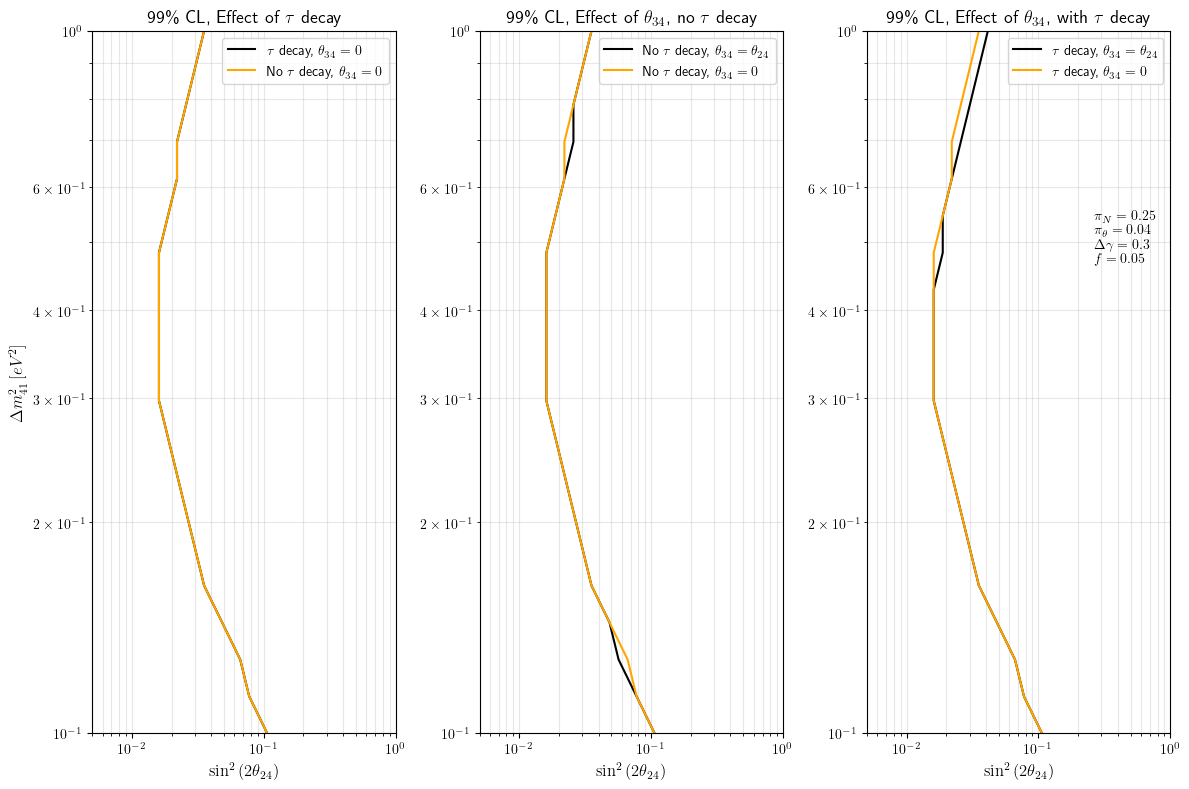

In [52]:
fig, ax = plt.subplots(1, 3, figsize=(12, 8))
ax = ax.flatten()

# ax[0].plot(giunti_contour_cl90.s24, giunti_contour_cl90.dm41, label='Giunti et al. (90% CL)',c='b')
# ax[0].plot(IC_contour_cl99.s24, IC_contour_cl99.dm41, label='IceCube',c='red',ls='--')
ax[0].plot(
    s24_cl90_tau_s24,
    dm41_cl90_tau_s24,
    label="$\\tau$ decay, $\\theta_{34}= 0$ ",
    c="black",
)
ax[0].plot(
    s24_cl90_notau_s24,
    dm41_cl90_notau_s24,
    label="No $\\tau$ decay, $\\theta_{34}=0$ ",
    c="orange",
)

# ax[1].plot(giunti_contour_cl99.s24, giunti_contour_cl99.dm41, label='Giunti et al. (99% CL)',ls='solid',c='b')
# ax[1].plot(IC_contour_cl99.s24, IC_contour_cl99.dm41, label='IceCube',c='red',ls='--')
ax[1].plot(
    s24_cl90_notau_s34,
    dm41_cl90_notau_s34,
    label="No $\\tau$ decay, $\\theta_{34}= \\theta_{24}$ ",
    c="black",
)
ax[1].plot(
    s24_cl90_notau_s24,
    dm41_cl90_notau_s24,
    label="No $\\tau$ decay, $\\theta_{34}=0$ ",
    c="orange",
)

ax[2].plot(
    s24_cl90_tau_s34,
    dm41_cl90_tau_s34,
    label="$\\tau$ decay, $\\theta_{34}= \\theta_{24}$ ",
    c="black",
)
ax[2].plot(
    s24_cl90_tau_s24,
    dm41_cl90_tau_s24,
    label="$\\tau$ decay, $\\theta_{34}=0$ ",
    c="orange",
)

ax[0].set_xscale("log")
ax[1].set_xscale("log")
ax[2].set_xscale("log")
ax[0].set_yscale("log")
ax[1].set_yscale("log")
ax[2].set_yscale("log")
ax[0].set_xlim((5e-3, 1))
ax[1].set_xlim((5e-3, 1))
ax[2].set_xlim((5e-3, 1))
ax[0].set_ylim((1e-1, 1))
ax[1].set_ylim((1e-1, 1))
ax[2].set_ylim((1e-1, 1))
ax[0].set_xlabel("$\sin^2{(2\\theta_{24})}$", fontsize=12)
ax[1].set_xlabel("$\sin^2{(2\\theta_{24})}$", fontsize=12)
ax[2].set_xlabel("$\sin^2{(2\\theta_{24})}$", fontsize=12)
ax[0].set_ylabel("$\\Delta m^2_{41} \, [eV^2]$", fontsize=12)
ax[0].grid(True, which="both", alpha=0.3)
ax[1].grid(True, which="both", alpha=0.3)
ax[2].grid(True, which="both", alpha=0.3)
ax[0].set_title("99\% CL, Effect of $\\tau$ decay", fontsize=13)
ax[1].set_title("99\% CL, Effect of $\\theta_{34}$, no $\\tau$ decay", fontsize=13)
ax[2].set_title("99\% CL, Effect of $\\theta_{34}$, with $\\tau$ decay", fontsize=13)

ax[0].legend()
ax[1].legend()
ax[2].legend()
plt.annotate(
    f"$\pi_N = {sigma_a}$\n$\pi_\\theta = {sigma_b}$\n$\Delta \gamma = {gamma}$\n$f = {f}$\n",
    xy=(0.75, 0.65),
    xycoords="axes fraction",
)
plt.tight_layout()

In [4]:
# Plots for Smirnov 2013
from plotter import P_over_E_parameter

temp_params = list_of_params(
    ic_params, np.array([0.2, 0.5, 1.0]), np.array([0.1]), np.array([0.1])
)
Pam = P_over_E_parameter(
    "m",
    param_dict_list=temp_params,
    E=np.logspace(3, 4, 50),
    zenith=-1,
    ndim=4,
    anti=True,
)
Pm = P_over_E_parameter(
    "m",
    param_dict_list=temp_params,
    E=np.logspace(3, 4, 50),
    zenith=-1,
    ndim=4,
    anti=False,
)
Pe = P_over_E_parameter(
    "e",
    param_dict_list=temp_params,
    E=np.logspace(3, 4, 50),
    zenith=-1,
    ndim=4,
    anti=False,
)
Pae = P_over_E_parameter(
    "e",
    param_dict_list=temp_params,
    E=np.logspace(3, 4, 50),
    zenith=-1,
    ndim=4,
    anti=True,
)

Pamam = Pam[:, 1]
Pamat = Pam[:, 2]
Pmm = Pm[:, 1]
Pmt = Pm[:, 2]
Pem = Pe[:, 1]
Paeam = Pae[:, 1]

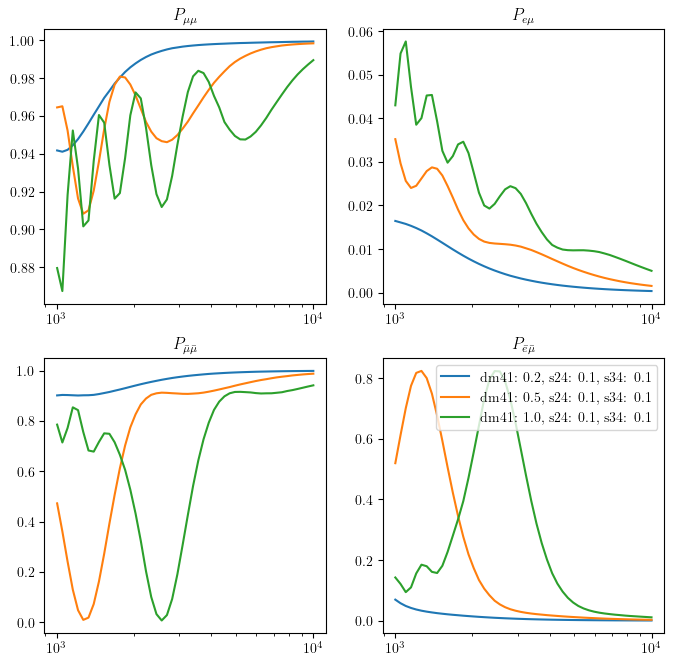

In [5]:
fig, ax = plt.subplots(2, 2, figsize=(8, 8))
ax = ax.flatten()
for i, prob in enumerate(Pmm):
    ax[0].plot(
        np.logspace(3, 4, 50),
        prob,
        label=f'dm41: {np.round(temp_params[i]["dm_41"],2)}, s24: {np.round(np.sin(2*temp_params[i]["theta_24"])**2,2)}, s34: {np.round(np.sin(2*temp_params[i]["theta_34"])**2,2)}',
    )
for i, prob in enumerate(Pmt):
    ax[1].plot(
        np.logspace(3, 4, 50),
        prob,
        label=f'dm41: {np.round(temp_params[i]["dm_41"],2)}, s24: {np.round(np.sin(2*temp_params[i]["theta_24"])**2,2)}, s34: {np.round(np.sin(2*temp_params[i]["theta_34"])**2,2)}',
    )
for i, prob in enumerate(Pamam):
    ax[2].plot(
        np.logspace(3, 4, 50),
        prob,
        label=f'dm41: {np.round(temp_params[i]["dm_41"],2)}, s24: {np.round(np.sin(2*temp_params[i]["theta_24"])**2,2)}, s34: {np.round(np.sin(2*temp_params[i]["theta_34"])**2,2)}',
    )
for i, prob in enumerate(Pamat):
    ax[3].plot(
        np.logspace(3, 4, 50),
        prob,
        label=f'dm41: {np.round(temp_params[i]["dm_41"],2)}, s24: {np.round(np.sin(2*temp_params[i]["theta_24"])**2,2)}, s34: {np.round(np.sin(2*temp_params[i]["theta_34"])**2,2)}',
    )
ax[0].set_xscale("log")
ax[1].set_xscale("log")
ax[2].set_xscale("log")
ax[3].set_xscale("log")

ax[0].set_title("$P_{\mu\mu}$")
ax[1].set_title("$P_{e\mu}$")
ax[2].set_title("$P_{\\bar{\mu}\\bar{\mu}}$")
ax[3].set_title("$P_{\\bar{e}\\bar{\mu}}$")
plt.legend()

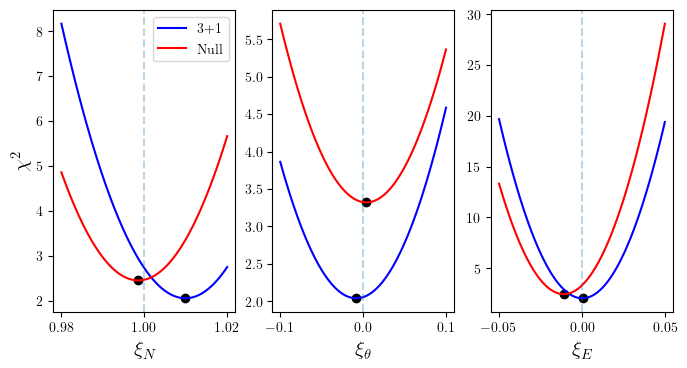

In [469]:
from functions import chisq

fig, ax = plt.subplots(1, 3)
c_range = np.linspace(-0.05, 0.05, 100)
b_range = np.linspace(-0.1, 0.1, 100)
a_range = np.linspace(0.98, 1.02, 100)
H1_a = [
    chisq(
        params=[a, best_a[1]],
        events=best_fit_events,
        data=IC_observed,
        sigma_syst=sigma_syst,
        z=zreco[0:-1],
        sigma_a=sigma_a,
        sigma_b=sigma_b,
        sigma_g=sigma_g,
    )
    for a in a_range
]
H0_a = [
    chisq(
        params=[a, best_a[1]],
        events=H0_normalized,
        data=IC_observed,
        sigma_syst=sigma_syst,
        z=zreco[0:-1],
        sigma_a=sigma_a,
        sigma_b=sigma_b,
        sigma_g=sigma_g,
    )
    for a in a_range
]
H0_min_a = np.argmin(H0_a)
H1_min_a = np.argmin(H1_a)
ax[0].plot(a_range, H1_a, label="3+1", c="blue")
ax[0].plot(a_range, H0_a, label="Null", c="red")
ax[0].scatter(a_range[H0_min_a], H0_a[H0_min_a], c="black")
ax[0].set_xlabel("$\\xi_N$", fontsize=15)
ax[0].set_ylabel("$\chi^2$", fontsize=15)
ax[0].scatter(a_range[H1_min_a], H1_a[H1_min_a], c="black")
ax[0].legend()
ax[0].axvline(x=1, linestyle="--", alpha=0.3)


H1_b = [
    chisq(
        params=np.array([best_a[0], b]),
        events=best_fit_events,
        data=IC_observed,
        sigma_syst=sigma_syst,
        z=zreco[0:-1],
        sigma_a=sigma_a,
        sigma_b=sigma_b,
        sigma_g=sigma_g,
    )
    for b in b_range
]
H0_b = [
    chisq(
        params=np.array([best_a[0], b]),
        events=H0_normalized,
        data=IC_observed,
        sigma_syst=sigma_syst,
        z=zreco[0:-1],
        sigma_a=sigma_a,
        sigma_b=sigma_b,
        sigma_g=sigma_g,
    )
    for b in b_range
]
H0_min_b = np.argmin(H0_b)
H1_min_b = np.argmin(H1_b)
ax[1].plot(b_range, H1_b, label="3+1", c="blue")
ax[1].plot(b_range, H0_b, label="Null", c="red")
ax[1].scatter(b_range[H0_min_b], H0_b[H0_min_b], c="black")
ax[1].set_xlabel("$\\xi_\\theta$", fontsize=15)
ax[1].scatter(b_range[H1_min_b], H1_b[H1_min_b], c="black")
ax[1].axvline(x=0, linestyle="--", alpha=0.3)

H1_c = [
    chisq(
        params=np.array([best_a[0], best_a[1], c]),
        events=best_fit_events,
        data=IC_observed,
        sigma_syst=sigma_syst,
        z=zreco[0:-1],
        sigma_a=sigma_a,
        sigma_b=sigma_b,
        sigma_g=sigma_g,
    )
    for c in c_range
]
H0_c = [
    chisq(
        params=np.array([best_a[0], best_a[1], c]),
        events=H0_normalized,
        data=IC_observed,
        sigma_syst=sigma_syst,
        z=zreco[0:-1],
        sigma_a=sigma_a,
        sigma_b=sigma_b,
        sigma_g=sigma_g,
    )
    for c in c_range
]
H0_min_c = np.argmin(H0_c)
H1_min_c = np.argmin(H1_c)
ax[2].plot(c_range, H1_c, label="3+1", c="blue")
ax[2].plot(c_range, H0_c, label="Null", c="red")
ax[2].scatter(c_range[H0_min_c], H0_c[H0_min_c], c="black")
ax[2].set_xlabel("$\\xi_E$", fontsize=15)
ax[2].scatter(c_range[H1_min_c], H1_c[H1_min_c], c="black")
ax[2].axvline(x=0, linestyle="--", alpha=0.3)

In [6]:
def get_best(
    H1_list_normalized,
    dm41_range,
    s24_range,
    delta_T,
    sigma=[0.25, 0.15],
    f=0.09,
    x0=[1, 0, 0],
):
    sigma_a = sigma[0]
    sigma_b = sigma[1]
    sigma_g = delta_T
    f = f
    sigma_syst = f * IC_observed
    x0 = x0
    # chisq_H0, a_H0 = perform_chisq(H0_normalized,IC_observed,z=zreco[0:-1],sigma_a=sigma_a,sigma_b=sigma_b,sigma_gamma=sigma_gamma , x0=x0)
    chisq_H1_list = np.array(
        [
            perform_chisq(
                H1_norm,
                IC_observed,
                sigma_syst=sigma_syst,
                z=zreco[0:-1],
                sigma_a=sigma_a,
                sigma_b=sigma_b,
                sigma_g=sigma_g,
                x0=x0,
            )[0]
            for H1_norm in H1_list_normalized
        ]
    )
    delta_chi = chisq_H1_list - np.min(chisq_H1_list)  # chisq_H1_list - chisq_H0

    best_fit_index = np.argmin(delta_chi)
    return best_fit_index


best_fit_index = get_best(
    H1_list_normalized,
    dm41_range,
    s24_range,
    delta_T,
    sigma=[0.25, 0.15],
    f=0.09,
    x0=[1, 0, 0],
)
best_fit_params = param_list[best_fit_index]

In [18]:
reshaped_H1 = np.array(H1_list_normalized).reshape(7, 7, 7, 10, 20)
best_s34 = np.argwhere(s34_range == np.sin(2 * best_fit_params["theta_34"]) ** 2).item()
H1_best_s34 = reshaped_H1[best_s34, :, :, :]
H1_list_best_s34 = H1_best_s34.reshape(7 * 7, 10, 20)

In [25]:
H1_lowest_s34 = reshaped_H1[0, :, :, :]
H1_list_lowest_s34 = H1_lowest_s34.reshape(7 * 7, 10, 20)

In [26]:
sigma_a = 0.4
sigma_b = 0.1
f = 0.13
s24_cl90, s24_cl99, dm41_cl90, dm41_cl99, best_index = get_contour(
    H1_list_best_s34,
    dm41_range,
    s24_range,
    delta_T,
    [sigma_a, sigma_b],
    f,
    x0=[1, 0, 0],
)
s24_cl90_low, s24_cl99_low, dm41_cl90_low, dm41_cl99_low, best_index = get_contour(
    H1_list_lowest_s34,
    dm41_range,
    s24_range,
    delta_T,
    [sigma_a, sigma_b],
    f,
    x0=[1, 0, 0],
)

Text(0.05, 0.65, '$\\pi_N = 0.4$\n$\\pi_\\theta = 0.1$\n$\\Delta \\gamma = 0.3$\n$f = 0.13$\n')

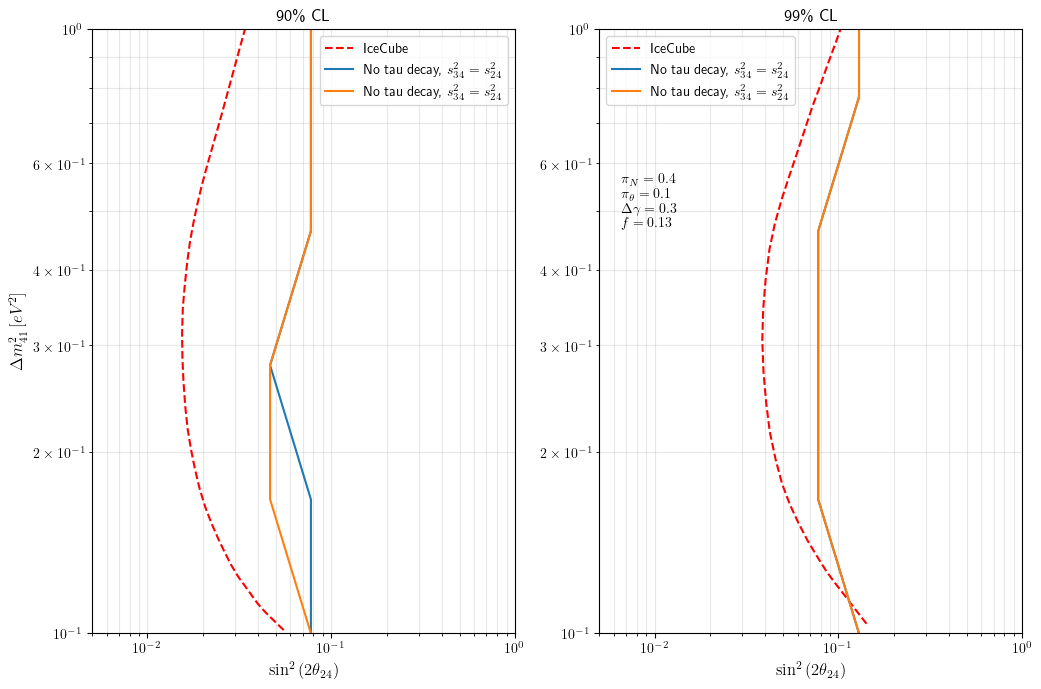

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(12, 8))

# ax[0].plot(giunti_contour_cl90.s24, giunti_contour_cl90.dm41, label='Giunti et al. (90% CL)',c='b')
ax[0].plot(IC_contour_cl90.s24, IC_contour_cl90.dm41, label="IceCube", c="red", ls="--")
ax[0].plot(s24_cl90, dm41_cl90, label="No tau decay, $s_{34}^2=s_{24}^2$ ")
ax[0].plot(s24_cl90_low, dm41_cl90_low, label="No tau decay, $s_{34}^2=s_{24}^2$ ")
# ax[1].plot(giunti_contour_cl99.s24, giunti_contour_cl99.dm41, label='Giunti et al. (99% CL)',ls='solid',c='b')
ax[1].plot(IC_contour_cl99.s24, IC_contour_cl99.dm41, label="IceCube", c="red", ls="--")
ax[1].plot(s24_cl99, dm41_cl99, label="No tau decay, $s_{34}^2=s_{24}^2$")
ax[1].plot(s24_cl99_low, dm41_cl99_low, label="No tau decay, $s_{34}^2=s_{24}^2$")

ax[0].set_xscale("log")
ax[1].set_xscale("log")
ax[0].set_yscale("log")
ax[1].set_yscale("log")
ax[0].set_xlim((5e-3, 1))
ax[1].set_xlim((5e-3, 1))
ax[0].set_ylim((1e-1, 1))
ax[1].set_ylim((1e-1, 1))
ax[0].set_xlabel("$\sin^2{(2\\theta_{24})}$", fontsize=12)
ax[1].set_xlabel("$\sin^2{(2\\theta_{24})}$", fontsize=12)
ax[0].set_ylabel("$\\Delta m^2_{41} \, [eV^2]$", fontsize=12)
ax[0].grid(True, which="both", alpha=0.3)
ax[1].grid(True, which="both", alpha=0.3)
ax[0].set_title("90\% CL")
ax[1].set_title("99\% CL")

ax[0].legend()
ax[1].legend()
plt.annotate(
    f"$\pi_N = {sigma_a}$\n$\pi_\\theta = {sigma_b}$\n$\Delta \gamma = {gamma}$\n$f = {f}$\n",
    xy=(0.05, 0.65),
    xycoords="axes fraction",
)

In [56]:
s24_cl90_index_list = []
s24_cl99_index_list = []
s34_cl90_index_list = []
s34_cl99_index_list = []
for x in [[1, 0, 0]]:  # [[1.],[1.,0.],[1.,0.,0.]]:
    sigma_a = 0.25
    sigma_b = 0.15
    sigma_g = delta_T
    f = 0.09
    sigma_syst = f * IC_observed
    x0 = x
    # chisq_H0, a_H0 = perform_chisq(H0_normalized,IC_observed,z=zreco[0:-1],sigma_a=sigma_a,sigma_b=sigma_b,sigma_gamma=sigma_gamma , x0=x0)
    chisq_H1_list = np.array(
        [
            perform_chisq(
                H1_norm,
                IC_observed,
                sigma_syst=sigma_syst,
                z=zreco[0:-1],
                sigma_a=sigma_a,
                sigma_b=sigma_b,
                sigma_g=sigma_g,
                x0=x0,
            )[0]
            for H1_norm in H1_list_normalized
        ]
    )
    delta_chi = chisq_H1_list - np.min(chisq_H1_list)  # chisq_H1_list - chisq_H0

    best_fit_index = np.argmin(delta_chi)
    best_fit_params = param_list[best_fit_index]
    best_fit_events = H1_list_normalized[best_fit_index]
    _, best_a = perform_chisq(
        H1_list_normalized[best_fit_index],
        IC_observed,
        sigma_syst=sigma_syst,
        z=zreco[0:-1],
        sigma_a=sigma_a,
        sigma_b=sigma_b,
        sigma_g=sigma_g,
        x0=x0,
    )
    p_value = chi2.sf(np.min(chisq_H1_list), 2)

    if len(best_a) == 2:
        a = best_a[0]
        b = best_a[1]
        H1_best = a * (1 + b * (0.5 + zreco[0:-1])) * best_fit_events
    elif len(best_a) == 1:
        H1_best = best_a * best_fit_events

    """
    print('best deltachi:', np.round(delta_chi[best_fit_index],4))
    print('best parameters:', best_a)
    #print('p-value:',p_value)
    print('best dm41:', np.round(best_fit_params['dm_41'],3))
    print('best s24:', np.round(np.sin(2*best_fit_params['theta_24'])**2,4))
    print('best s34:', np.round(np.sin(2*best_fit_params['theta_34'])**2,4))
    #print('best th24:', best_fit_params['theta_24'])
    #print(delta_chi)
    """

    deltachi_reshaped = delta_chi.reshape(len(s24_range), len(s34_range))
    cl_99_bool = np.where(deltachi_reshaped < chi2.ppf(q=0.99, df=2), True, False)
    cl_90_bool = np.where(deltachi_reshaped < chi2.ppf(q=0.90, df=2), True, False)

    s24_cl90_index = get_boundary(cl_90_bool.T)
    s34_cl90_index = np.linspace(
        0, len(s24_cl90_index) - 1, len(s24_cl90_index)
    ).astype("int")
    s24_cl99_index = get_boundary(cl_99_bool.T)
    s34_cl99_index = np.linspace(
        0, len(s24_cl99_index) - 1, len(s24_cl99_index)
    ).astype("int")

    s24_cl90_index_list.append(s24_cl90_index)
    s24_cl99_index_list.append(s24_cl99_index)
    s34_cl90_index_list.append(s34_cl90_index)
    s34_cl99_index_list.append(s34_cl99_index)

Text(0.05, 0.65, '$\\pi_N = 0.25$\n$\\pi_\\theta = 0.15$\n$\\Delta \\gamma = 0.3$\n$f = 0.09$\n')

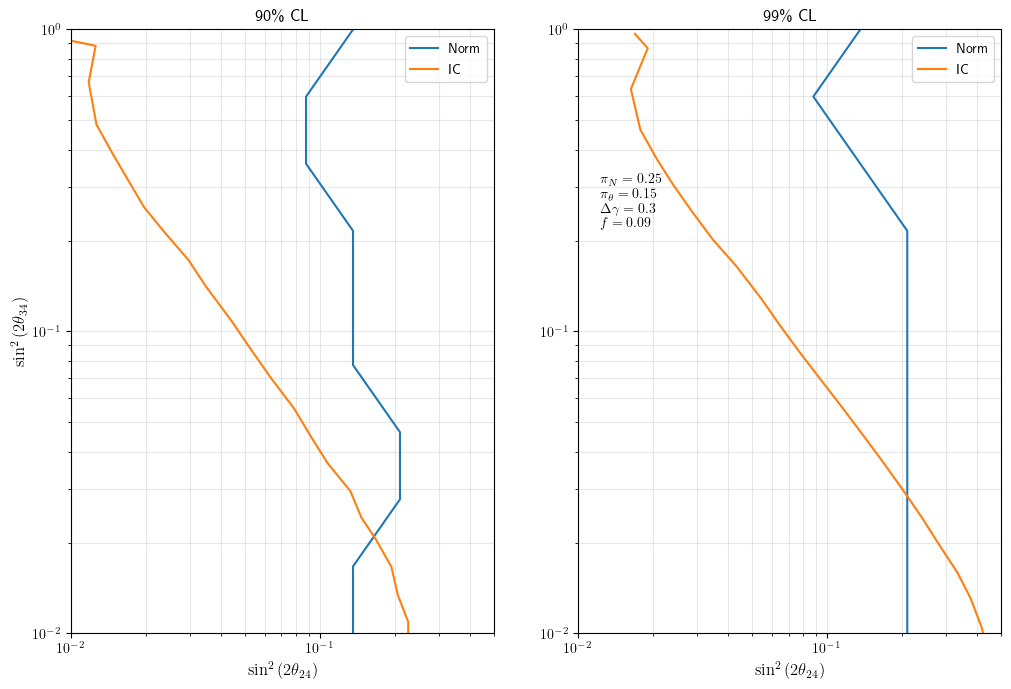

In [57]:
fig, ax = plt.subplots(1, 2, figsize=(12, 8))

# ax[0].plot(giunti_contour_cl90.s24, giunti_contour_cl90.dm41, label='Giunti et al. (90% CL)',c='b')
# ax[0].plot(IC_contour_cl90.s24, IC_contour_cl90.dm41, label='IceCube',c='red',ls='--')
ax[0].plot(
    s24_range[s24_cl90_index_list[0]], s34_range[s34_cl90_index_list[0]], label="Norm"
)
ax[0].plot(ic_34_cl90.s24, ic_34_cl90.s34, label="IC")
# ax[0].plot(s24_range[s24_cl90_index_list[1]], dm41_range[dm41_cl90_index_list[1]], label='Norm + zenith')
# ax[0].plot(s24_range[s24_cl90_index_list[2]], dm41_range[dm41_cl90_index_list[2]], label='Norm + zenith + tilt')

# ax[1].plot(giunti_contour_cl99.s24, giunti_contour_cl99.dm41, label='Giunti et al. (99% CL)',ls='solid',c='b')
# ax[1].plot(IC_contour_cl99.s24, IC_contour_cl99.dm41, label='IceCube',c='red',ls='--')
ax[1].plot(
    s24_range[s24_cl99_index_list[0]], s34_range[s34_cl99_index_list[0]], label="Norm"
)
ax[1].plot(ic_34_cl99.s24, ic_34_cl99.s34, label="IC")
# ax[1].plot(s24_range[s24_cl99_index_list[1]], dm41_range[dm41_cl99_index_list[1]], label='Norm + zenith')
# ax[1].plot(s24_range[s24_cl99_index_list[2]], dm41_range[dm41_cl99_index_list[2]], label='Norm + zenith + tilt')


ax[0].set_xscale("log")
ax[1].set_xscale("log")
ax[0].set_yscale("log")
ax[1].set_yscale("log")
ax[0].set_xlim((s24_range.min(), s24_range.max()))
ax[1].set_xlim((s24_range.min(), s24_range.max()))
ax[0].set_ylim((s34_range.min(), s34_range.max()))
ax[1].set_ylim((s34_range.min(), s34_range.max()))
ax[0].set_xlabel("$\sin^2{(2\\theta_{24})}$", fontsize=12)
ax[1].set_xlabel("$\sin^2{(2\\theta_{24})}$", fontsize=12)
ax[0].set_ylabel("$\sin^2{(2\\theta_{34})}$", fontsize=12)
ax[0].grid(True, which="both", alpha=0.3)
ax[1].grid(True, which="both", alpha=0.3)
ax[0].set_title("90\% CL")
ax[1].set_title("99\% CL")

ax[0].legend()
ax[1].legend()
plt.annotate(
    f"$\pi_N = {sigma_a}$\n$\pi_\\theta = {sigma_b}$\n$\Delta \gamma = {gamma}$\n$f = {f}$\n",
    xy=(0.05, 0.65),
    xycoords="axes fraction",
)

# interpolare contour mesh